In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from utils.BBI_utils import mergeData, computeBBI, simpleLowpassFilter, getSuperelevation, getAdvisorySpeed, alignData
from utils.LRS_utils import NCATgetReferencePoints, getDistToMid, getReferenceCurve, NCATgetRadius
from utils.NCAT_processing import NCAT_processing
from utils.SR_processing import SR_processing


loc = pd.read_csv(r'2021_03_11_07_36_21_506_loc.csv')
acc = pd.read_csv(r'2021_03_11_07_36_21_506_acc.csv')
crash = pd.read_csv(r'Crashdata.csv')
# Chooses certain columns
crash = crash.filter(items=['Road_Name', 'KABCO_Seve', 'Manner_of_', 'Location_a', 'Latitude', 'Longitude'])
# Filters out all collision based crashes
crash = crash[crash['Manner_of_'].eq('Not a Collision with Motor Vehicle')]
# Filters out intersection crashes
crash = crash[crash['Location_a'].str.contains('Non-Intersection') | crash['Location_a'].eq('Off Roadway')]
print(crash)
print(crash.shape)
# SR_obj = SR_processing(inFiles=[r'2021_03_11_07_36_21_506_loc.csv',r'2021_03_11_07_36_21_506_acc.csv'])
print(acc.columns)
print(loc.columns)
print(loc)
# Not sure why this merge doesn't work...
# all_csv_data = pd.merge(left=loc, right=acc, how='left', left_on='timestamp_utc_local', right_on='timestamp_nanosecond')
all_csv_data = pd.concat([loc, acc], axis=1)
print(all_csv_data)
road_17 = gpd.read_file('0017_D1_2/0017_D1_2.shp')
# print(SR_obj.gdf)

ModuleNotFoundError: No module named 'geopandas'

In [2]:
def SmartPhoneProcessing(self, inFiles, dt):
        """
        Cominbe tables
        Create GeoDataFrame
        Set crs and project to crs with unit of feet
        find reference points
        compute track dist of each point
        find range idx of each lap
        """
        print('Processing Smartphone Data ... ', end='')
        # merge acceleration, gps and gyro data
        df = mergeData(inFiles, dt=dt, col_keywords=[
                       "local", "timestamp"], new_col_name="local_timestamp_utc", GoPro=False)
        # compute BBI
        df = computeBBI(df, zero_range=[0, 10], lowpass_alpha=self.lowpassAlpha, x_acc_label='accel_y_mps2', y_acc_label='accel_x_mps2')
        # Check if radius calculation need to have the sign flipped
        zero_vector = getZeroVector(df, [0, 10], x_acc_label='accel_y_mps2', y_acc_label='accel_x_mps2')
        if zero_vector[1] > 0:
            flip_sign_flag = False
        else:
            flip_sign_flag = True
        # filter GYRO
        df['angvelocity_x_radps'] = simpleLowpassFilter(df['angvelocity_x_radps'].tolist(), alpha=float(self.lowpassAlpha))
        # make GeoDataFrame
        self.gdf = geopandas.GeoDataFrame(
            df, geometry=geopandas.points_from_xy(df['longitude_dd'], df['latitude_dd']))
        self.gdf = self.gdf.set_crs("epsg:4326")
        self.gdf = self.gdf.to_crs("EPSG:32166")
        # process data
        self.gdf['Track_dist'] = self.gdf.apply(
            lambda row: self.center_line.geometry[0].project(row['geometry']), axis=1)

        self.gdf['Dist_to_mid'] = self.gdf.apply(lambda row: getDistToMid(
            row['Track_dist'], self.track_length, self.referencePoints), axis=1)

        self.gdf['Reference_curve'] = self.gdf.apply(lambda row: getReferenceCurve(
            row['Track_dist'], self.referencePoints), axis=1)

        self.interpolateMeasuredSuper()

        self.gdf['Radius'] = self.gdf.apply(
            lambda row: NCATgetRadius(row['Dist_to_mid']), axis=1)

        self.gdf['adv_speed_measured'] = self.gdf.apply(lambda row: getAdvisorySpeed(
            row['Measured_Superelevation'], row['Radius']), axis=1)

        self.gdf['Superelevation'] = self.gdf.apply(lambda row: getSuperelevation(
            row['speed_ms'], row['Radius'], row['BBI_computed_filtered'], k=self.suspension_para), axis=1)

        self.gdf['adv_speed'] = self.gdf.apply(lambda row: getAdvisorySpeed(
            row['Superelevation'], row['Radius']), axis=1)
        
        self.gdf['Radius_GYRO'] = self.gdf.apply(lambda row: GYROgetRadius(
            row['speed_ms'], row['angvelocity_x_radps'], flip_sign=flip_sign_flag), axis=1)
        
        self.gdf['Superelevation_GYRO'] = self.gdf.apply(lambda row: getSuperelevation(
            row['speed_ms'], row['Radius_GYRO'], row['BBI_computed_filtered'], k=self.suspension_para), axis=1)

        self.gdf['adv_speed_GYRO'] = self.gdf.apply(lambda row: getAdvisorySpeed(
            row['Superelevation_GYRO'], row['Radius']), axis=1)
        
        self.gdf['Side_friction_angle'] = self.gdf.apply(
            lambda row: backCalculateBBI(row['speed_ms'], row['Radius_GYRO'], row['Measured_Superelevation']), axis=1)
        
        self.idx_range = getRangeIndex(self.gdf, 'Track_dist', self.mid_NT_dist)

        self.getLapNumber()

        print('Done!')

0    LINESTRING Z (2515783.921 1671794.719 0.000, 2...
Name: geometry, dtype: geometry
<class 'geopandas.geodataframe.GeoDataFrame'>
{'init': 'epsg:2240'}
{'init': 'epsg:2240'}
{'init': 'epsg:2240'}
   FID_0017_D  FID_Distri  OBJECTID  GDOT_DISTR  \
0           2           0         1           1   

                                 GlobalID last_edite  FID_0017 Route_Numb  \
0  {AD4BC9BE-3FD8-4506-9A13-4BD2D4353A5F}       None         0       0017   

   BUFF_DIST  ORIG_FID  FID_0017_1  FID_Dist_1  OBJECTID_2  GDOT_DIS_1  \
0        1.0         0           0           0           1           1   

                               GlobalID_1 last_edi_1  FID_001_18 Route_Nu_1  \
0  {AD4BC9BE-3FD8-4506-9A13-4BD2D4353A5F}       None           0       0017   

      Shape_Leng                                           geometry  
0  206506.370329  LINESTRING Z (2515783.921 1671794.719 0.000, 2...  


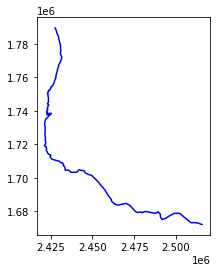

In [24]:
print(road_17.geometry)

# print(road_17)
print(type(road_17))
print(road_17.geometry.crs)
print(road_17.geometry.crs)
print(road_17.crs)
base = road_17.plot(color='blue')
print(road_17)
# road_17.plot()

{'init': 'epsg:2240'}
{'init': 'epsg:2240'}


<AxesSubplot:>

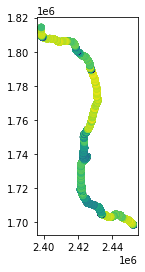

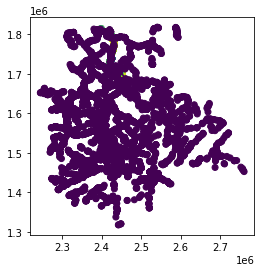

In [29]:
smartphone = gpd.GeoDataFrame(
    loc, geometry=gpd.points_from_xy(x=loc.longitude_dd, y=loc.latitude_dd)
)
road_17['speed'] = [0]
smartphone['speed'] = loc[' speed_ms']

smartphone = gpd.GeoDataFrame(smartphone, geometry=smartphone['geometry'])
smartphone.crs = {'init' :'epsg:4326'}
#smartphone = smartphone.to_crs({'init' :'epsg:4326'}) 


print(road_17.crs)
smartphone = smartphone.to_crs(road_17.crs)
# road_17 = road_17.to_crs(smartphone.crs)
print(smartphone.crs)
smartphone.plot(column='speed');

combined = smartphone.append(road_17)
from shapely.geometry import Point
#print(road_17.geometry.project(Point(1,2)))
#print(road_17.geometry.interpolate(114994.071224))
#print(type(road_17.geometry))
sections = gpd.GeoSeries()
for x in np.arange(0, 10000, 50):
    point = road_17.geometry.interpolate(x)
    sections = sections.append(point)

crash_points = gpd.GeoDataFrame(
    crash, geometry=gpd.points_from_xy(x=crash.Longitude, y=crash.Latitude)
)
crash_points.crs = {'init' :'epsg:4326'}
crash_points = crash_points.to_crs(road_17.crs)
crash_points['speed'] = 5
# for index, row in all_csv_data.iterrows():
#     to_interpolate = road_17.geometry.project(Point(row['longitude_dd'], row['latitude_dd']))
#     print(to_interpolate)
#     point = road_17.geometry.interpolate(to_interpolate)
#     print(point)
#     sections = sections.append(point)
#     if (index > 500):
#         break
sections = gpd.GeoDataFrame(geometry=sections)
sections['speed'] = 5
combined = combined.append(sections)
combined = combined.append(crash_points)
combined.plot(column='speed')
# smartphone.plot()

In [11]:
import cv2
import numpy as np

# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture('camera/2021_06_03_14_57_18_660_cam_2021_06_03_14_57_18_660.mp4')

# Check if camera opened successfully
if (cap.isOpened()== False): 
    print("Error opening video stream or file")

# Read until video is completed
while(cap.isOpened()):
  # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
        # Display the resulting frame
        cv2.imshow('Frame',frame)

        # Press Q on keyboard to  exit
        key = cv2.waitKey(25)
        if key == 32:
            cv2.waitKey()
        elif key & 0xFF == ord('q'):
            break
        
  # Break the loop
    else: 
        break

# When everything done, release the video capture object
cap.release()

# Closes all the frames
cv2.destroyAllWindows()


hello


In [14]:
from IPython.display import Video

Video("camera/2021_06_03_14_57_18_660_cam_2021_06_03_14_57_18_660.mp4")